# PyTorch (Lightning) integration

This package includes an integration with PyTorch that allows you to convert an `ImageSequence` into a PyTorch `Dataset` in a single line of code. This can then be used to train models using PyTorch and derived frameworks, such als [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning). This notebook showcases the use and walks you through the whole process from loading data to training the model.

In [1]:
import pvinspect as pv
from pvinspect.integration.pytorch import ClassificationDataset
import pytorch_lightning as pl
import torch as t
import torchvision as tv
from typing import List
from sklearn import model_selection
import numpy as np

## Step 1: Set up `LightningModule`

We set up a very basic `LightningModule` for classification of defects on solar cells. We omit the dataloaders, since we pass them in dynamically lateron. For more information, please refer to the [docs](https://pytorch-lightning.readthedocs.io/en/stable/).

In [2]:
class DefectModel(pl.LightningModule):

    def __init__(
        self,
        pos_weight: List[float],
        learning_rate: float,
    ):
        super().__init__()

        # let's use a very small resnet
        self.model = tv.models.ResNet(tv.models.resnet.BasicBlock, layers=[1, 1, 1, 1], num_classes=2)

        self.pos_weight = t.tensor(pos_weight)
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return {'loss': t.nn.functional.binary_cross_entropy_with_logits(y_hat, y, pos_weight=self.pos_weight.to(x))}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return {'loss': t.nn.functional.binary_cross_entropy_with_logits(y_hat, y, pos_weight=self.pos_weight.to(x))}

    def configure_optimizers(self):
        return t.optim.Adam(self.parameters(), lr=self.learning_rate)

## Step 2: Load data

Here, we'll use the cell images provided with the [ELPV dataset](https://github.com/zae-bayern/elpv-dataset) [[1](http://dx.doi.org/10.1016/j.solener.2019.02.067)]. This toolbox provides a convenience method for loading this data as well as additional defect annotations. In addition, a split in training and test data is provided by the meta property `testset`. Here, we'll only use the training data.

In [3]:
all_data = pv.data.datasets.elpv().pandas.query('testset == False')
all_data.meta_to_pandas()

100%|██████████| 2624/2624 [00:06<00:00, 426.74it/s]


,blob,crack,defect_probability,finger,inactive,modality,path,testset,wafer
0,False,True,1.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,mono
1,False,True,1.000000,True,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,mono
2,False,True,1.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,mono
3,False,False,0.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,mono
4,True,False,1.000000,True,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,mono
...,...,...,...,...,...,...,...,...,...
2319,False,False,0.333333,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,poly
2320,False,False,0.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,poly
2321,False,False,0.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,poly
2322,False,False,0.000000,False,False,Modality.EL_IMAGE,c:\users\mathis\dev\pvinspect\pvinspect\data\d...,False,poly


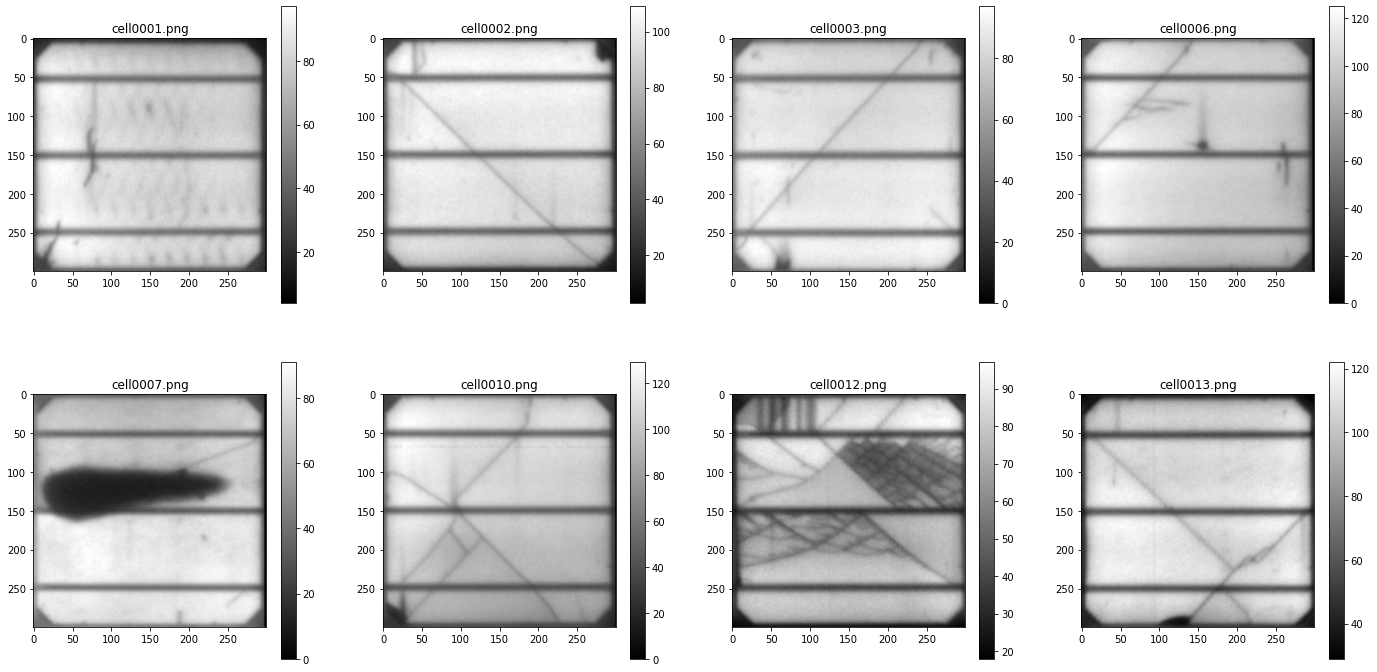

In [4]:
all_data.pandas.query('crack == True').head(N=8, cols=4)

## Step 3: Train/validation split

We'll train for two of the defect classes (`crack` and `inactive`). To this end, we map labels into the label powerset and use this to perform a stratified 80/20 split.

In [5]:
# generate label powerset
is_crack = np.array(all_data.meta_to_pandas()['crack'].to_list())*1
is_inactive = np.array(all_data.meta_to_pandas()['inactive'].to_list())*2
labels = is_crack+is_inactive

# perform stratified split of sample ids
idx_train, idx_val = model_selection.train_test_split(list(range(len(all_data))), test_size=0.8, stratify=labels)


# get subsets using sample ids
train_data = all_data.pandas.iloc[idx_train]
val_data = all_data.pandas.iloc[idx_val]

## Step 4: Generate class weights

The dataset is highly imbalanced. To this end, we compute weights for the two classes as follows:

In [6]:
n_samples = len(train_data)
n_crack = len(train_data.pandas.query('crack == True'))
n_inactive = len(train_data.pandas.query('inactive == True'))
pos_weight = [n_crack / (n_samples-n_crack), n_inactive / (n_samples-n_inactive)]

## Step 5: Compute statistics for normalization

Here, we compute the mean and standard deviation using the first 50 images, since we do (not yet) support auto calibration, like you might know it from FastAI. However, we plan to [implement this](https://github.com/ma0ho/pvinspect/issues/6).

In [7]:
mean = np.mean([x.data for x in train_data.pandas.iloc[:50]])
std = np.std([x.data for x in train_data.pandas.iloc[:50]])
(mean, std)

(154.2729388888889, 43.677714868576984)

## Step 6: Set up data augmentation pipeline

This is as usual using PyTorch transforms. However, we support any data augmentation library that results in callable transform-objects. 

In [8]:
train_tfms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize((150, 150)),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomAffine(degrees=10),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([mean/255], [std/255]),  # statistics are computed on original images (uint8)
    tv.transforms.Lambda(lambda x: x.repeat(3,1,1))
])
val_tfms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.Resize((150, 150)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([mean/255], [std/255]),
    tv.transforms.Lambda(lambda x: x.repeat(3,1,1))
])

## Step 7: Convert `ImageSequence`s into `Dataset`s and create `DataLoader`s

This is the main part of the PyTorch integration. Here, `pv.integration.pytorch.ClassificationDataset` extends `pv.integration.pytorch.Dataset`, which itself extends the PyTorch `Dataset`. Note that we are not restricted to classification tasks, since we can use the more general purpose `pv.integration.pytorch.Dataset` instead. However, `ClassificationDataset` conveniently converts meta attributes listet in the `meta_classes` attribute into one-hot tensors. Furthermore, it allows to convert classification results back into meta attributes of the `ImageSequence` using the [`result_sequence`](https://ma0ho.github.io/pvinspect/integration/pytorch/dataset.html#pvinspect.integration.pytorch.dataset.ClassificationDataset.result_sequence) method (not shown here).

In [9]:
train_ds = ClassificationDataset(train_data, meta_classes=['crack', 'inactive'], data_transform=train_tfms)
val_ds = ClassificationDataset(train_data, meta_classes=['crack', 'inactive'], data_transform=val_tfms)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

## Step 8: Set up `Trainer` and train model

Now, set up a PyTorch Lightning `Trainer` and train the model using `train_dl` and `val_dl`.

In [10]:
model = DefectModel(pos_weight, 1e-4)

In [11]:
trainer = pl.Trainer(gpus=1, logger=None, progress_bar_refresh_rate=20, max_epochs=2)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [12]:
trainer.fit(model, train_dl, val_dl)


  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 4 M   
INFO:lightning:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 4 M   
Epoch 1:  34%|███▍      | 20/58 [00:03<00:07,  5.26it/s, loss=0.340]
Validating: 0it [00:00, ?it/s]
Epoch 2:  34%|███▍      | 20/58 [00:01<00:03, 10.24it/s, loss=0.141]
Validating: 0it [00:00, ?it/s]
Epoch 2:  69%|██████▉   | 40/58 [00:04<00:02,  8.63it/s, loss=0.127]


1

## References

[[1](http://dx.doi.org/10.1016/j.solener.2019.02.067)] Deitsch, S.; Christlein, V.; Berger, S.; Buerhop-Lutz, C.; Maier, A.; Gallwitz, F. & Riess, C. Automatic classification of defective photovoltaic module cells in electroluminescence images. Solar Energy, Elsevier BV, 2019, 185, 455-468.